In [2]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from retrievalnet.evaluation import compute_recall, is_gt_match_3D
from descriptor_index_pb2 import DescriptorIndex
from utils import plot_imgs
%load_ext autoreload
%autoreload 2

INDEX_ROOT = '../global-loc/data/'
MAP_ROOT = '../global-loc/maps/'

In [19]:
def get_index(name):
    index = DescriptorIndex()
    with open(Path(INDEX_ROOT, name).as_posix(), 'rb') as f:
        index.ParseFromString(f.read())
    return index
def get_data_from_index(index):
    positions = np.stack([f.position_vector.data for f in index.frames])
    rotations = np.stack([np.reshape(f.rotation_matrix.data, (3, 3), order='C') for f in index.frames])
    descriptors = np.stack([f.global_descriptor.data for f in index.frames])
    resources = np.stack([f.resource_name for f in index.frames])
    return {'pos': positions, 'rot': rotations, 'descriptors': descriptors, 'res': resources}
def tango_recall(ref_name, query_name, distance_thresh=4, angle_thresh=70*np.pi/180., *arg, **kwarg):
    ref_data = get_data_from_index(get_index(ref_name))
    query_data = get_data_from_index(get_index(query_name))
    gt_matches = is_gt_match_3D(query_data, ref_data, distance_thresh, angle_thresh)
    return compute_recall(ref_data['descriptors'], query_data['descriptors'], gt_matches, *arg, **kwarg)

# Recall

lindenhof_{}_aligned_resnet-pool.pb                0.873 recall@10
lindenhof_{}_aligned_resnet-pool.pb_proj           0.878 recall@10
lindenhof_{}_aligned_netvlad.pb                    0.930 recall@10
lindenhof_{}_aligned_netvlad.pb_proj               0.932 recall@10
lindenhof_{}_aligned_mobilenet-d0.35.pb            0.899 recall@10
lindenhof_{}_aligned_mobilenet-d0.35.pb_proj       0.916 recall@10


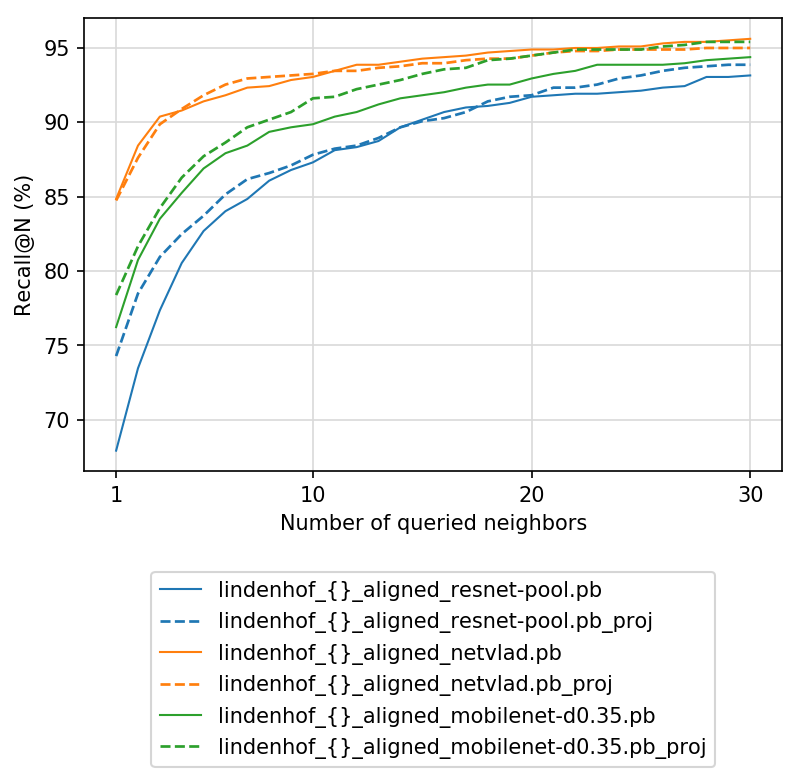

In [21]:
experiments = [
    'lindenhof_{}_aligned_resnet-pool.pb',
    'lindenhof_{}_aligned_netvlad.pb',
    'lindenhof_{}_aligned_mobilenet-d0.35.pb',
]
ref_name = 'afternoon'
query_name = 'wet'
max_num_nn = 30
pca_dim = 512
print_recall_at = 10

plt.figure(dpi=150)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
for e, c in zip(experiments, colors):
    m = tango_recall(e.format(ref_name), e.format(query_name), max_num_nn=max_num_nn, pca_dim=0)
    plt.plot(1+np.arange(len(m)), 100*m, label=e, color=c, linewidth=1);
    print('{:<50} {:.3f} recall@{}'.format(e, m[print_recall_at-1], print_recall_at))
    
    m = tango_recall(e.format(ref_name), e.format(query_name), max_num_nn=max_num_nn, pca_dim=pca_dim)
    plt.plot(1+np.arange(len(m)), 100*m, label=e+'_proj', color=c, linewidth=1.3, linestyle='--');
    print('{:<50} {:.3f} recall@{}'.format(e+'_proj', m[print_recall_at-1], print_recall_at))
    
plt.xticks([1]+np.arange(10, max_num_nn+1, step=10).tolist()); plt.grid(color=[0.85]*3);
plt.legend(loc=9, bbox_to_anchor=(0.5, -0.2));
plt.xlabel('Number of queried neighbors'), plt.ylabel('Recall@N (%)');

# NN search run-time, recall, and PCA dimensionality

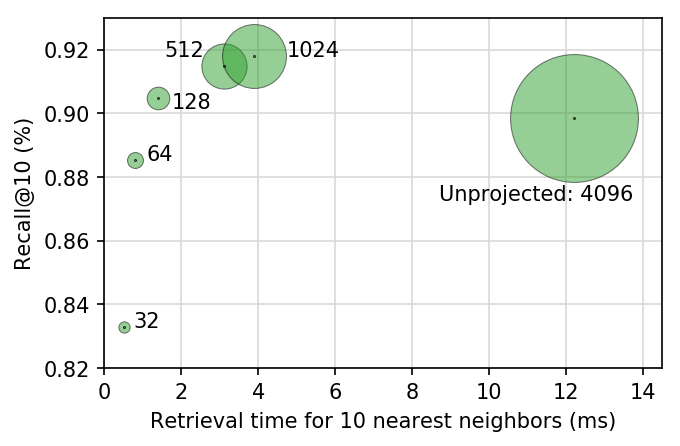

In [24]:
experiment = 'lindenhof_{}_aligned_mobilenet-d0.35.pb'
ref_name = 'afternoon'
query_name = 'wet'

dims = [32, 64, 128, 512, 1024, 0]
timings = [0.5, 0.8, 1.4, 3.1, 3.9, 12.2]
annotations = ['{}'.format(d) for d in dims[:-1]] + ['Unprojected: 4096']
offsets = [(0.25, 0), (0.3, 0), (0.34, -0.003), (-1.55, 0.003), (0.84, 0), (-3.5, -0.026)]

plt.figure(figsize=(4.8, 3.2), dpi=150)
for d, t, a, o in zip(dims, timings, annotations, offsets):
    r = tango_recall(experiment.format(ref_name), experiment.format(query_name),
                     max_num_nn=10, pca_dim=d)[-1]
    plt.scatter(t, r, label=experiment, c=colors[2], s=(d if d != 0 else 4096)*0.92, 
                edgecolors='k', linewidths=0.5, zorder=10, alpha=0.5)
    plt.scatter(t, r, marker='.', c='k', zorder=11, s=0.5)
    plt.annotate(a, xy=(t+o[0], r+o[1]))
    
plt.ylim(0.82, 0.93); plt.xlim(0, 14.5);
plt.grid(color=[0.85]*3); plt.gcf().subplots_adjust(bottom=0.15)
plt.xlabel('Retrieval time for 10 nearest neighbors (ms)'), plt.ylabel('Recall@10 (%)');